# Sentiment Analysis on Movie Reviews using Naive Bayes Classifier

In [2]:
#Importing all the neccessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.model_selection import cross_validate
#from sklearn import cross_validation
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import scikitplot.metrics as sciplot
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import math
from sklearn.decomposition import TruncatedSVD

<b> Data Source: <b> https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

### Attribute Information: 

1. Phrase Id
2. Sentiment Id
3. Phrase
4. Sentiment

#### Objective: 

Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.

#### While pre-processing the original dataset we have taken into consideration the following points. 

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 3 or 4.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 0 or 1.
3. We will ignore the reviews for the time being which has a Score rating of 2. Because 2 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset.
5. We will train our final model using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
6. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative.

## Reading Raw Data 

In [3]:
data = pd.read_csv('data.tsv.zip', delimiter='\t')
# data= data[1:1000]
print("shape",np.shape(data))
data.head(5)

shape (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
final_data=data
final_data['SentimentPolarity'] = final_data['Sentiment'].apply(lambda x : 'Positive' if x > 2 else 'Negative')
final_data['Class_Labels'] = final_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)
final_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,SentimentPolarity,Class_Labels
0,1,1,A series of escapades demonstrating the adage ...,1,Negative,0
1,2,1,A series of escapades demonstrating the adage ...,2,Negative,0
2,3,1,A series,2,Negative,0
3,4,1,A,2,Negative,0
4,5,1,series,2,Negative,0


<AxesSubplot:title={'center':'Distribution Of Positive and Negative reviews'}>

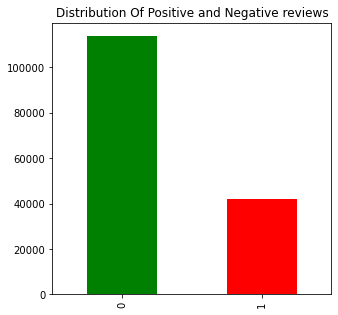

In [5]:
#Display distribution of Postive and Negative reviews in a bar graph
final_data["Class_Labels"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews',figsize=(5,5))

## Preprocessing 

### Preprocessing Review 

Our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [6]:
#Printing some random reviews.
sent_1 = final_data['Phrase'].values[0]
print(sent_1)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[0]))
print("="*215)

sent_2 = final_data['Phrase'].values[1000]
print(sent_2)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1000]))
print("="*215)

sent_3 = final_data['Phrase'].values[1500]
print(sent_3)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1500]))
print("="*215)

sent_4 = final_data['Phrase'].values[4900]
print(sent_4)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[4900]))
print("="*215)

sent_5 = final_data['Phrase'].values[12566]
print(sent_5)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[12566]))
print("="*215)


A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
Review Polarity: Negative
to avoid
Review Polarity: Negative
convolutions
Review Polarity: Negative
pointless extremes
Review Polarity: Negative
Dignified CEO 's meet at a rustic retreat and pee against a tree .
Review Polarity: Negative


In [7]:
#Remove urls from text python: https://stackoverflow.com/a/40823105/4084039
import re
sent_1 = re.sub(r"http\S+", " ", sent_1)
sent_2 = re.sub(r"http\S+", " ", sent_2)
sent_3 = re.sub(r"http\S+", " ", sent_3)
sent_4 = re.sub(r"http\S+", " ", sent_4)
sent_5 = re.sub(r"http\S+", " ", sent_5)


print(sent_1,"\n")
print("="*215)
print(sent_2,"\n")
print("="*215)
print(sent_3,"\n")
print("="*215)
print(sent_4,"\n")
print("="*215)
print(sent_5,"\n")
print("="*215)


A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story . 

to avoid 

convolutions 

pointless extremes 

Dignified CEO 's meet at a rustic retreat and pee against a tree . 



In [8]:
#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text


print(removeHtml(sent_1) + "\n")
print(removeHtml(sent_2) + "\n")
print(removeHtml(sent_3) + "\n")
print(removeHtml(sent_4) + "\n")
print(removeHtml(sent_5) + "\n")


A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .

to avoid

convolutions

pointless extremes

Dignified CEO 's meet at a rustic retreat and pee against a tree .



In [9]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
import re

#Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

In [10]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
'''
>>> import re
>>> s = "ABCD abcd AB55 55CD A55D 5555"
>>> re.sub("\S*\d\S*", "", s).strip()

'ABCD abcd'
>>>'''

sent_1 = re.sub("\S*\d\S*", " ", sent_1).strip()
print(sent_1)

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .


In [11]:
'''Data Cleaning Stage.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

''' pattern = re.compile('<.*?>') #Function to clean html tags from a sentence
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text'''

#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)
    
#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

In [12]:
#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not

100%|████████████████████████████████████████████████████████████████████████| 10221/10221 [00:00<00:00, 568318.66it/s]


Text(0, 0.5, 'Number of Words')

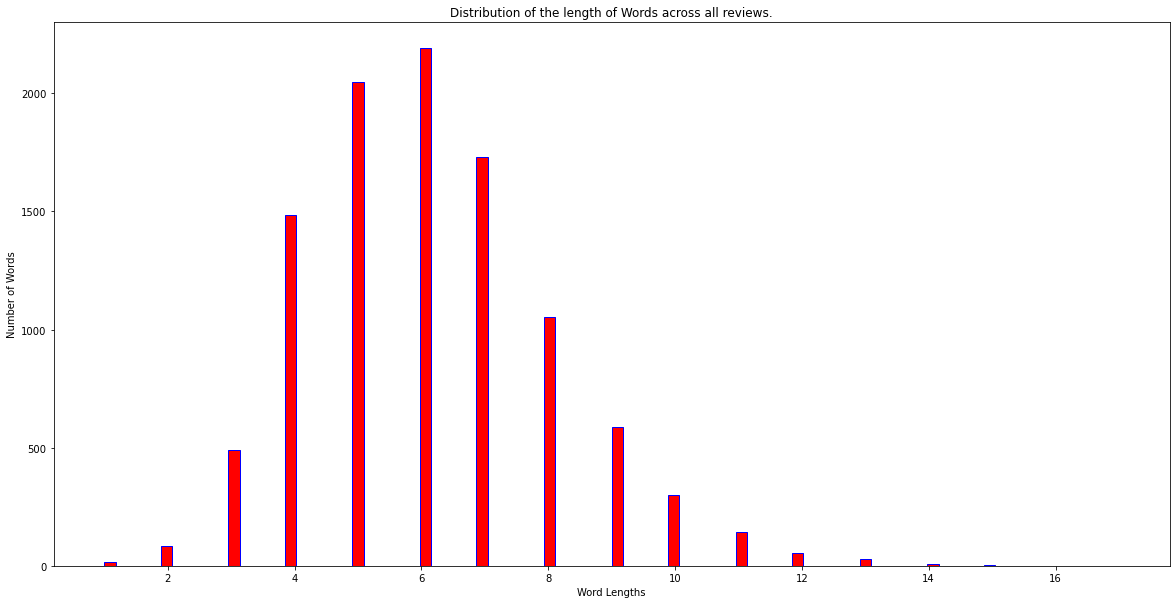

In [13]:
#We will check the distribution of stemmed word lengths across the whole review dataset to understand what is the length of the maximum number of words we will consider for the word to be relevant.
#In other words we will keep only those words which has a length less than that of a speicific length (we will obtain this specific length from the histogram).
from tqdm import tqdm
total_words = []

for review in tqdm(final_data['Phrase'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords)):          
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)

total_words = list(set(total_words)) #Get list of unique words.

#A list to hold the length of each words used in all the reviews used across the whole dataset.
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)

# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(20,10))
plt.hist(dist, color = 'red', edgecolor = 'blue', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

### Conclusion from the above histogram: 

We can see that most stemmed words present in the reviews has lengths between 3 and 10. Words which has length greater than 13 are very very very few as compared to other words. So we will discard these words from the reviews when we process them. It means we will consider only those words whose length is greater than 2 and less than 13.

In [14]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(final_data['Phrase'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (final_data['SentimentPolarity'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(final_data['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Save the list of positive words and negative words
import pickle
with open('all_positive_words.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews

100%|████████████████████████████████████████████████████████████████████████| 156060/156060 [00:39<00:00, 3916.73it/s]


The length of the data corpus is : 156060


### In this code block : 

1. We define a function which is used to perform column standardization on any give input matrix.
2. We define a function which is used to get the top 50 features from both the negative and the positive review classes.
3. We define a function which is used to measure the various performance metrics for a given model. We will use accuracy as a metric to evaluate this models performance on unseen data.
4. We define a function which is used to obtain the optima value of alpha along with the best mnodel estimator, using time series cross validation along with grid search CV.
5. We define a function which is used to plot and visually represent the errors vs hyperparameter plot.
6. We fit the naive base classifier to our training data and make the final model.

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

def standardize(X_train_vectors, X_test_vectors):
    '''Function used to column standardize any given matrix'''
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean=False)
    scalar.fit(X_train_vectors)
    X_train_vectors = scalar.transform(X_train_vectors)
    X_test_vectors = scalar.transform(X_test_vectors)
    print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
    print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))
    return (X_train_vectors, X_test_vectors)

def top_features(nb_classifier, vectorizer_object):
    '''Get top 50 features displayed from both the negative and the positive review classes.'''
    neg_class_prob_sorted = (-nb_classifier.feature_log_prob_[0, :]).argsort()               #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    pos_class_prob_sorted = (-nb_classifier.feature_log_prob_[1, :]).argsort()
    neg_class_features = np.take(vectorizer_object.get_feature_names(), neg_class_prob_sorted[:50])
    pos_class_features = np.take(vectorizer_object.get_feature_names(), pos_class_prob_sorted[:50])
    print("The top 50 most frequent words from the positive class are :\n")
    print(pos_class_features)
    print("\nThe top 50 most frequent words from the negative class are :\n")
    print(neg_class_features)
    del(neg_class_prob_sorted, pos_class_prob_sorted, neg_class_features, pos_class_features)

def performance(nb_classifier, vectorizationType, X_train, y_train, X_test, y_test, optimal_alpha, mse): #MSE : Mean Squared Loss
    '''Function to measure the various performance metrics for a given model.'''
    print("\n'''PERFORMANCE EVALUATION'''")
    print("\n\nDetailed report for the {} Vectorization.".format(vectorizationType))

    #Predict the labels for the test set.
    y_pred = nb_classifier.predict(X_test)
    
    #Evaluate the accuracy of the model on test set
    test_accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100
    points = accuracy_score(y_test, y_pred, normalize=False)
    print('\nThe number of accurate predictions out of {} data points on unseen data is {}'.format(X_test.shape[0], points))
    print('Accuracy of the {} model on unseen data is {} %'.format(vectorizationType, np.round(test_accuracy,2)))
    
    #Get the precision, recall and F1 score for this model.
    print("Precision of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.precision_score(y_test ,y_pred),4)))
    print("Recall of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.recall_score(y_test ,y_pred),4)))
    print("F1 score of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.f1_score(y_test ,y_pred),4)))
    
    #Classification Report
    print ('\nClasification report for {} model : \n'.format(vectorizationType))
    print(metrics.classification_report(y_test,y_pred))
    
    #Print the Conclusions on the trained dataset
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    p = tp+fn #p = total number of actual postives
    n = fp+tn #p = total number of actual negatives
    TPR = tp/p ; TNR = tn/n ; FPR = fp/n ; FNR = fn/p
    print("\nThe True Positives Rate is : {}".format(TPR))
    print("The True Negatives Rate is : {}".format(TNR))
    print("The False Positives Rate is : {}".format(FPR))
    print("The False Negatives Rate is : {}".format(FNR))
    
    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metrics.precision_score(y_test ,y_pred)*100,2)))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metrics.recall_score(y_test ,y_pred)*100,2)))
      
    #Save the below list for later use to display model information
    info_model_NB = [vectorizationType, optimal_alpha, np.round(np.array(mse).mean(),4), np.round(1-metrics.accuracy_score(y_test, y_pred),4), np.round(metrics.f1_score(y_test ,y_pred),4), points]
    with open('info_model_NB.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_NB)
        filehandle.writelines("\n")
        
    #Get the confusion matrix for the running model
    print("\nFind below the confusion matrix for {} model.".format(vectorizationType))
    sciplot.plot_confusion_matrix(y_test ,y_pred)
    
    #Free memory allocations
    del(X_train, y_train, X_test, y_test, vectorizationType, y_pred, nb_classifier)
       
def get_GridSearchCV_estimator(vectorizationType, X_train, y_train, X_test, y_test):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Grid Search, using 10 fold cross validation. '''
    from sklearn.model_selection import TimeSeriesSplit
    alphas = np.logspace(-5, 4, 100)
    tuned_parameters = [{'alpha': alphas}]
    n_folds = 10
    model = MultinomialNB()
    gsearch_cv = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=10, scoring='f1', n_jobs=6)
    gsearch_cv.fit(X_train, y_train)
    print("\nGridSearchCV completed for {} model!".format(vectorizationType))
    print("Best estimator for {} model : ".format(vectorizationType), gsearch_cv.best_estimator_)
    print("Best Score for {} model : ".format(vectorizationType), gsearch_cv.best_score_)
    return gsearch_cv
    
def plot_errors(gsearch_cv):
    '''This function is used to plot the curve for mean squared errors vs alpha values'''
    #Get cross validation scores. Here we obtain the alpha values and their corresponding mean test scores.
    cv_result = gsearch_cv.cv_results_         
    mts = cv_result["mean_test_score"]        #list that will hold the mean of cross validation accuracy scores for each alpha
    alphas = cv_result["params"]

    alpha_values = []                         #list that will hold all the alpha values that the grid search cross validator tried.
    for i in range(0,len(alphas)):
        alpha_values.append(alphas[i]["alpha"])

    #Changing accuracy to mean squared error. **error = 1 - accuracy ; error = Cross Validation Errors, accuracy = Cross Validation accuracy
    mse = [1 - x for x in mts]

    #Determining best alpha from errors. 'alpha' will be best for the lowest value for error
    optimal_alpha = alpha_values[mse.index(min(mse))] #Laplace smoothing
    print('The optimal value of alpha is : {}'.format(optimal_alpha))     

    #Plot error vs alpha values
    plt.figure(figsize=(35,8))
    plt.plot(alpha_values , mse, color='green', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='red', markersize=10)
    for xy in zip(alpha_values, np.round(mse,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title('Plot for Errors vs Alpha Values')
    plt.xlabel('Values of Alpha')
    plt.ylabel('Errors')
    plt.show()
    
    return (optimal_alpha,mse)
    
def naive_bayes_algorithm(X_train, y_train, X_test, y_test, vectorizationType, vectorizer_object):
    '''This function splits the dataset into training set and test sets. The test data remains untouched.
    A time series 10 fold cross validation is performed on the train data and the value of optimal alpha is calculated. 
    The dataset is then trained with this value of optimal alpha. 
    Finally the Naive Bayes model is used to predict its accuracy on the future unseen test set.'''
    
    #Perform 10-fold cross validation on the train set
    print("Starting Cross Validation steps...")
    gsearch_cv = get_GridSearchCV_estimator(vectorizationType, X_train, y_train, X_test, y_test)
    
    #Plot the graphical representation of the mean squared error vs the alpha values obtained during cross validation.
    optimal_alpha, mse = plot_errors(gsearch_cv)

    #Initialize the Naive Bayes constructor using alpha = optimal_alpha
    nb_classifier = gsearch_cv.best_estimator_

    #Fit the model to the train set using optimal alpha
    nb_classifier.fit(X_train, y_train)
    
    #Display the top features of both the negative and positive reviews
    top_features(nb_classifier, vectorizer_object)
    
    #Evaluate the model's performance
    performance(nb_classifier, vectorizationType, X_train, y_train, X_test, y_test, optimal_alpha, mse)

### Naive Bayes on the Bag of Words model created using 'CleanedText'. 

A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling, such as with machine learning algorithms. The approach is very simple and flexible, and can be used in a myriad of ways for extracting features from documents. Suppose we have N reviews in our dataset and we want to convert the words in our reviews to vectors. We can use BOW as a method to do this. What it does is that for each unique word in the data corpus, it creates a dimension. Then it counts how many number of times a word is present in a review. And then this number is placed under that word for a corresponding review. We will get a Sparse Matrix representation for all the worods inthe review.


Creating the BOW vectors using the cleaned corpus
The shape of the X_train_vectors is : (124848, 9129)
The shape of the X_test_vectors is : (31212, 9129)
Starting Cross Validation steps...

GridSearchCV completed for Bag-of-Words model!
Best estimator for Bag-of-Words model :  MultinomialNB(alpha=657.9332246575682)
Best Score for Bag-of-Words model :  0.5111148124321805
The optimal value of alpha is : 657.9332246575682


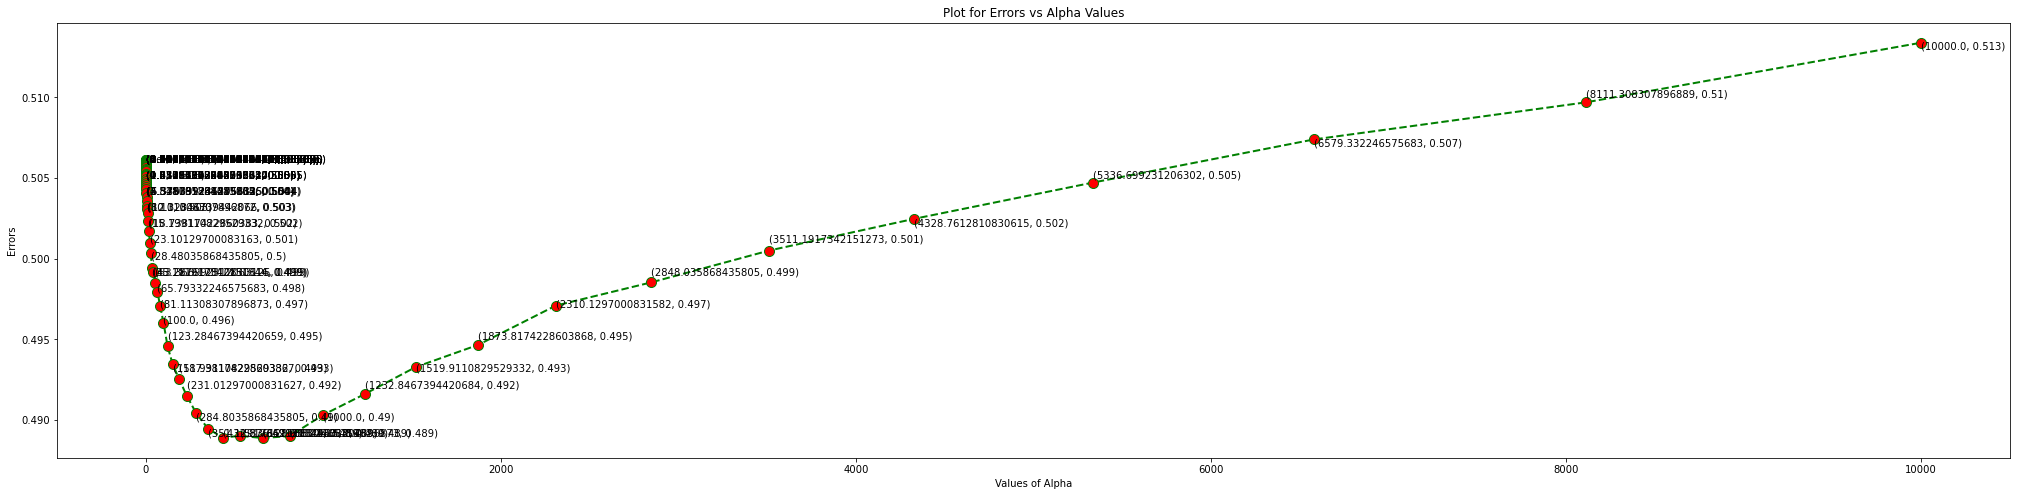

The top 50 most frequent words from the positive class are :

['film' 'good' 'movi' 'perform' 'funni' 'best' 'one' 'make' 'love' 'well'
 'entertain' 'beauti' 'stori' 'enjoy' 'great' 'power' 'comedi' 'heart'
 'work' 'fun' 'charact' 'not' 'life' 'visual' 'surpris' 'perfect' 'charm'
 'time' 'humor' 'cast' 'solid' 'smart' 'fascin' 'sweet' 'touch' 'intellig'
 'compel' 'delight' 'enough' 'director' 'remark' 'emot' 'wonder' 'move'
 'rich' 'engag' 'human' 'like' 'look' 'see']

The top 50 most frequent words from the negative class are :

['not' 'movi' 'film' 'like' 'one' 'charact' 'rrb' 'stori' 'make' 'bad'
 'much' 'time' 'lrb' 'would' 'littl' 'way' 'even' 'get' 'plot' 'thing'
 'come' 'comedi' 'seem' 'minut' 'look' 'feel' 'end' 'life' 'action' 'self'
 'director' 'work' 'long' 'tri' 'two' 'never' 'mani' 'audienc' 'could'
 'watch' 'think' 'lack' 'new' 'made' 'want' 'less' 'may' 'anoth' 'old'
 'hard']

'''PERFORMANCE EVALUATION'''


Detailed report for the Bag-of-Words Vectorization.

The number 

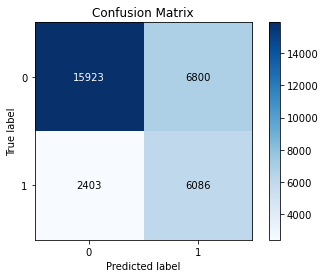

In [16]:
'''Creating the Bag of Words vector for the cleaned reviews.'''
#Bag of Words model creation using cleaned text 

sampled_dataset = final_data

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText']
y = sampled_dataset['Class_Labels']
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the BOW constructor
cv_object = CountVectorizer().fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)

#Colum Standardization of the Bag of Words vector created using cleaned data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations. 
del(sampled_dataset, X, y, X_train, X_test)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Bag-of-Words", cv_object)

### Naive Bayes on the TF-IDF model created using 'CleanedText' texts. 

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

Let's assume we have data corpus D, which contains N reviews {r1,r2,r3,r4...rN}. Let's say our review r1 contains the following words {w1,w2,w3,w1,w9,w6,w7,w9,w9}.

TF or Term Frequency for a word is basically the number of times a word occurs in a review divided by the total number of words present in that same review. For example, in the text corpus that we have considered in the above example, the TF for word w1 is (2/9) and for word w9 is (1/3). Intuitively, higher the occurence of a word in a text is, greater will be its TF value. TF values lies between 0 and 1.

IDF or Inverse Document Frequency for a word is given by the formula log(N/n), where 'N' is equal to the total number of reviews in the corpus 'D' and 'n' refers to the number of reviews in 'D' which contains that specific word. Intuitively, IDF will be higher for words which occur rarely and will be less for words which occurs more frequently. IDF values are more than 0.

So for each word in each review we will consider the product of (TF x IDF), and represent it in a d dimensional vector.

TF-IDF basically doesn't consider the semantic meaning of words. But what is does is that it gives more importance to words which occurs less frequently in the whole data corpus and also gives much importance to the most frequent words that occurs in each review.


Creating the TFIDF vectors using the cleaned corpus
The shape of the X_train_vectors is : (124848, 9129)
The shape of the X_test_vectors is : (31212, 9129)
Starting Cross Validation steps...

GridSearchCV completed for TF-IDF model!
Best estimator for TF-IDF model :  MultinomialNB(alpha=432.87612810830615)
Best Score for TF-IDF model :  0.5123420326630495
The optimal value of alpha is : 432.87612810830615


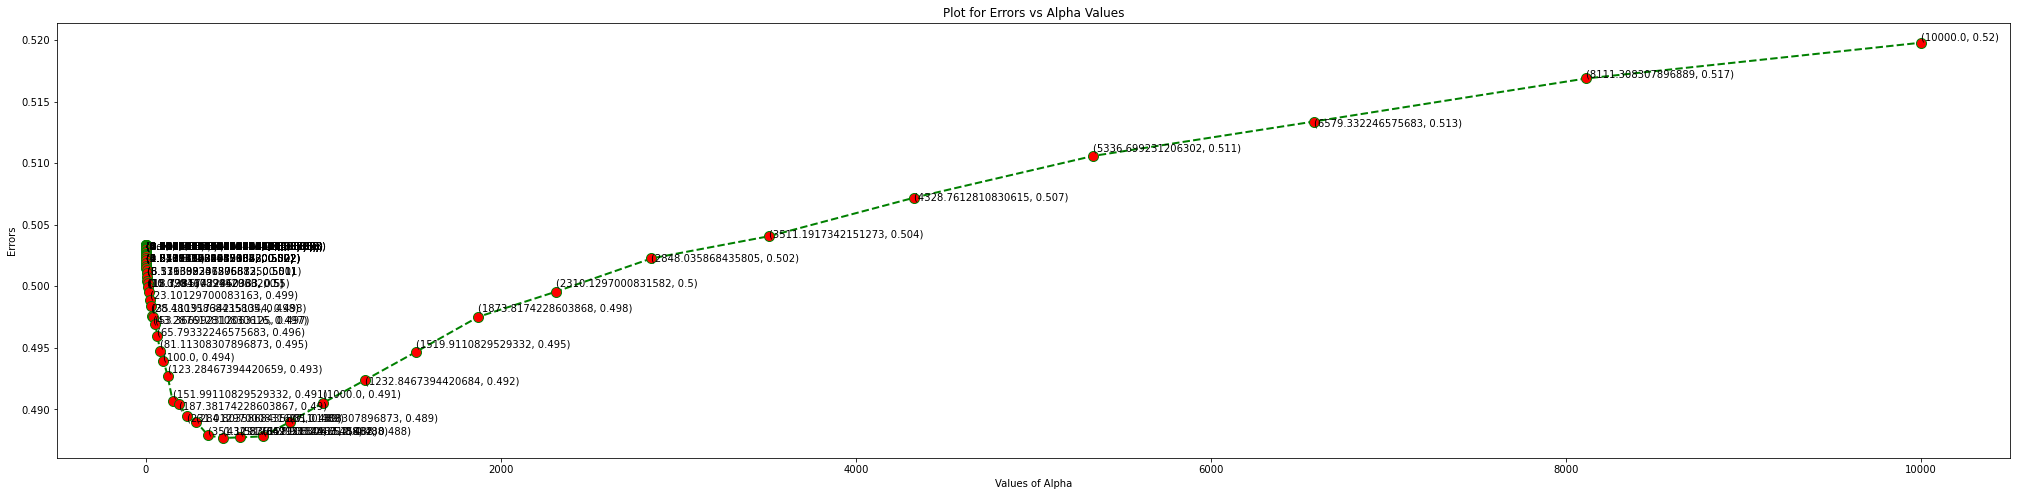

The top 50 most frequent words from the positive class are :

['film' 'good' 'funni' 'best' 'movi' 'perform' 'well' 'love' 'entertain'
 'beauti' 'enjoy' 'great' 'one' 'make' 'fun' 'power' 'heart' 'comedi'
 'stori' 'perfect' 'work' 'visual' 'fascin' 'charm' 'intellig' 'compel'
 'surpris' 'sweet' 'solid' 'humor' 'delight' 'smart' 'touch' 'remark'
 'charact' 'enough' 'rich' 'wonder' 'cast' 'interest' 'move' 'worth'
 'engag' 'life' 'satisfi' 'emot' 'time' 'director' 'hilari' 'like']

The top 50 most frequent words from the negative class are :

['not' 'movi' 'film' 'like' 'one' 'charact' 'rrb' 'make' 'stori' 'bad'
 'lrb' 'time' 'much' 'would' 'littl' 'way' 'even' 'get' 'plot' 'come'
 'comedi' 'thing' 'life' 'feel' 'seem' 'end' 'self' 'look' 'minut'
 'action' 'mani' 'two' 'work' 'long' 'director' 'never' 'tri' 'new'
 'audienc' 'could' 'may' 'old' 'think' 'less' 'lack' 'anoth' 'everi'
 'watch' 'peopl' 'made']

'''PERFORMANCE EVALUATION'''


Detailed report for the TF-IDF Vectorization.

The 

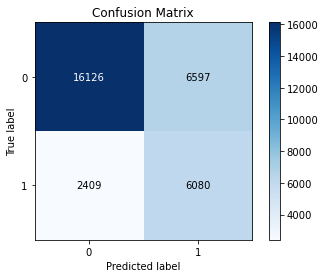

In [17]:
'''TF-IDF model creation using text reviews. HTML tags and punctuations are removed. All stopwords are preserved.'''


sampled_dataset = final_data

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText']
y = sampled_dataset['Class_Labels']
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the TF-IDF contructor
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the TFIDF vectors using the cleaned corpus")
X_train_vectors = tf_idf_object.transform(X_train)
X_test_vectors = tf_idf_object.transform(X_test)

#Colum Standardization of the TF-IDF vector created using cleaned data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations.
del(sampled_dataset, X, y)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "TF-IDF", tf_idf_object)

### Conclusion : 

From the below comparison chart we can see get an idea aboout how the different vectorizers perform.

In [20]:
#Compare performance and display it on a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", " Hyper-Parameter Value (alpha=)", "Train Error", "Test Error", "F1-Score", "No. Of accurate predictions"]

print("Please find below the important metrics for all the models below.\n")
file = open('info_model_NB.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table[7:9])

Please find below the important metrics for all the models below.

+--------------+---------------------------------+-------------+------------+----------+-----------------------------+
|    Model     |  Hyper-Parameter Value (alpha=) | Train Error | Test Error | F1-Score | No. Of accurate predictions |
+--------------+---------------------------------+-------------+------------+----------+-----------------------------+
| Bag-of-Words |        657.9332246575682        |    0.5028   |   0.2949   |  0.5695  |            22009            |
|    TF-IDF    |        432.87612810830615       |    0.501    |   0.2885   |  0.5745  |            22206            |
+--------------+---------------------------------+-------------+------------+----------+-----------------------------+
